## Range bias between Sentinel-1A and Sentinel-1B

In [1]:
%matplotlib inline
import os
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt, ticker, colors, patches
from mintpy.objects import timeseries
from mintpy.utils import ptime, readfile, writefile, utils as ut, plot as pp, s1_utils
plt.rcParams.update({'font.size': 12})

work_dir = os.path.expanduser('~/Papers/2022_Geolocation/figs_src/S1')
os.chdir(work_dir)
print('Go to directory', work_dir)

Go to directory /Users/yunjunz/Papers/2021_Geolocation/figs_src/S1


### Read and fit time-series

In [2]:
def get_timeseries_with_bias_est(ts_file, lalo):
    proj_dir = os.path.dirname(ts_file)
    lookup_file = os.path.join(proj_dir, 'inputs/geometryRadar.h5')
    # read data
    dates, ts_dis, ts_std = ut.read_timeseries_lalo(lat=lalo[0], lon=lalo[1], ts_file=ts_file, lookup_file=lookup_file,
                                                    win_size=20, method='mean', unit='cm', print_msg=True)
    # estimate S1AB bias
    (bias_AB, flagA, flagB,
     dates_fit, ts_fitA, ts_fitB) = s1_utils.estimate_S1AB_bias(os.path.dirname(ts_file), dates, ts_dis)
    print('S1 A/B est. bias [cm]:', bias_AB)

    # shift S1A to median zero
    shift = np.nanmedian(ts_dis[flagA])
    ts_dis -= shift
    ts_fitA -= shift
    ts_fitB -= shift

    return dates, ts_dis, ts_std, bias_AB, flagA, flagB, dates_fit, ts_fitA, ts_fitB

print('warm up utils functions.')

warm up utils functions.


### Plot (a) - Point Time Teries

input lat / lon: 32.82 / -116.05
corresponding y / x: 669 / 331
S1 A/B est. bias [cm]: [9.7888565]
S1A/B # of dates: 42 / 43
S1A/B date range: 2019-08-22 00:00:00 / 2021-01-07 00:00:00
save figure to file /Users/yunjunz/Papers/2021_Geolocation/figs_src/S1/bias_TS.pdf


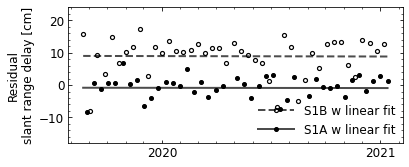

In [9]:
# input file & pts
#ts_file = os.path.expanduser('~/data/geolocation/ChileSenDT156/mintpy_offset/timeseriesRg_SET_ERA5.h5');         lalo = [-21.45, -69.15]  # IW3
ts_file = os.path.expanduser('~/data/offset4motion/SaltonSeaSenDT173/mintpy_offset_v4/timeseriesRg_SET.h5'); lalo = [32.82, -116.05]  # IW2

# read data
dates, ts_dis, ts_std, bias, flagA, flagB, dates_fit, ts_fitA, ts_fitB = get_timeseries_with_bias_est(ts_file, lalo=lalo)
flag = flagA | flagB
print('S1A/B # of dates: {} / {}'.format(np.sum(flagA), np.sum(flagB)))
print('S1A/B date range: {} / {}'.format(np.min(dates[flag]), np.max(dates[flagB])))

# plot
cs = ['k', 'k']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[6, 2.5], sharey=True)
p0B, = ax.plot(dates_fit, ts_fitB, '--', color=cs[1], alpha=0.7, lw=2)
p0A, = ax.plot(dates_fit, ts_fitA, '-',  color=cs[0], alpha=0.7, lw=2)
p1B, = ax.plot(dates[flagB], ts_dis[flagB], 'o', color=cs[1], mfc='none', ms=4, mew=1.2, label='S1B')
p1A, = ax.plot(dates[flagA], ts_dis[flagA], 'o', color=cs[0], mfc=cs[0],  ms=4, mew=1.0, label='S1A')

# axis format
ax.tick_params(which='both', axis='both', direction='in', top=True, bottom=True, left=True, right=True)
pp.auto_adjust_xaxis_date(ax, dates[flagB], buffer_year=None)
ax.set_ylim(-18, 24)
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_ylabel('Residual\nslant range delay [cm]')
ax.legend(handles=[(p0B, p1B), (p0A, p1A)], labels=['S1B w linear fit', 'S1A w linear fit'], loc='lower right', ncol=1, handlelength=3.0, frameon=False, borderaxespad=0.2)

# output
out_fig = os.path.join(work_dir, 'bias_TS.pdf')
print('save figure to file', out_fig)
#plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### Plot (b) - Bias Map

The 2D map distribution of the range bias between S1A and S1B shows clear subswath dependence.

save figure to file /Users/yunjunz/Papers/2021_Geolocation/figs_src/S1/bias_map.pdf


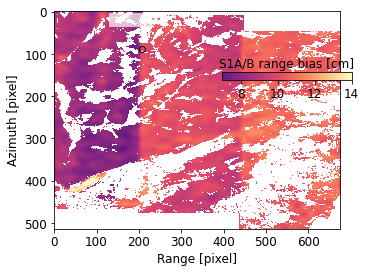

In [10]:
# read
ts_data = readfile.read(ts_file)[0]
date_list = timeseries(ts_file).get_date_list()
dates = ptime.date_list2vector(date_list)[0]
length, width = ts_data.shape[-2:]

# estimate
bias_est = s1_utils.estimate_S1AB_bias(os.path.dirname(ts_file), dates, ts_data)[0].reshape(ts_data.shape[1:]) * 100.
bias_est[bias_est == 0] = np.nan

# plot setup
vmin, vmax = 7, 14
cmap = colors.LinearSegmentedColormap.from_list('magma_t', plt.get_cmap('magma')(np.linspace(0.3, 1.0, 100)))
extent = (-0.5, width-0.5, int(length*0.65)-0.5, -0.5)

# plot
fig, ax = plt.subplots(figsize=[6, 4])
im = ax.imshow(bias_est, vmin=7, vmax=14, cmap=cmap, interpolation='nearest', extent=extent)
ax.plot(208, 119*0.75, 'ko', mfc='none')  #from print out msg above

# axis format
ax.tick_params(which='both', direction='out', bottom=True, top=False, left=True, right=False)
ax.set_xlabel('Range [pixel]')
ax.set_ylabel('Azimuth [pixel]')

# colorbar
ax.add_patch(patches.Rectangle((130, 3), 100, 33, ec='none', facecolor='white', alpha=0.7))
cax = fig.add_axes([0.57, 0.64, 0.3, 0.03])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal', ticks=[8, 10, 12, 14])
cbar.set_label('S1A/B range bias [cm]')
cax.xaxis.set_label_position('top')

# output
out_fig = os.path.join(work_dir, 'bias_map.pdf')
print('save figure to file', out_fig)
#plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=1200)
plt.show()

### Estimate bias for each subswath from ChileSenDT156 + write to HDF5 file

In [11]:
# estimate optimal (median) value for each subswath from SenDT156
geom_file = os.path.join(os.path.dirname(ts_file), 'inputs/geometryRadar.h5')
hgt, atr = readfile.read(geom_file, datasetName='height')
flag = hgt != 0
mlist = s1_utils.get_subswath_masks(flag, cut_overlap_in_half=False)[:3]
blist = [np.nanmedian(bias_est[mask]) for mask in mlist]
print('Median S1A/B bias in IW1 / IW2 / IW3 [cm]: {:.1f} / {:.1f} / {:.1f}'.format(blist[0], blist[1], blist[2]))

# create S1AB_bias.h5 file for SenDT156
bias_file = os.path.join(os.path.dirname(geom_file), 'S1Bias.h5')
bias_mat = np.zeros(flag.shape, dtype=np.float32) * np.nan
for bias, mask in zip(blist, mlist):
    bias_mat[mask] = bias / 100.
atr['FILE_TYPE'] = 'offset'
atr['UNIT'] = 'm'
print('writing S1A/B bias to file: {}'.format(bias_file))
writefile.write(bias_mat, out_file=bias_file, metadata=atr)

Median S1A/B bias in IW1 / IW2 / IW3 [cm]: 8.4 / 9.9 / 10.7
writing S1A/B bias to file: /Users/yunjunz/data/offset4motion/SaltonSeaSenDT173/mintpy_offset_v4/inputs/S1Bias.h5
create HDF5 file: /Users/yunjunz/data/offset4motion/SaltonSeaSenDT173/mintpy_offset_v4/inputs/S1Bias.h5 with w mode
create dataset /offset of float32    in size of (792, 677)           with compression=None
finished writing to /Users/yunjunz/data/offset4motion/SaltonSeaSenDT173/mintpy_offset_v4/inputs/S1Bias.h5


'/Users/yunjunz/data/offset4motion/SaltonSeaSenDT173/mintpy_offset_v4/inputs/S1Bias.h5'

### Plot the history of bias estimate

save figure to file /Users/yunjunz/Papers/2021_Geolocation/figs_src/S1/bias_hist.pdf


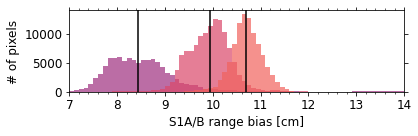

In [12]:
clist = ['C0', 'C1', 'C2']
clist = [cmap((bias - vmin) / (vmax - vmin)) for bias in blist]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[6, 1.5], sharey=True)
for bias, mask, c in zip(blist, mlist, clist):
    ax.hist(bias_est[mask].flatten(), bins=70, range=(7, 14), density=False, alpha=0.7, color=c)
    ax.axvline(bias, color='k')
# plot median value
ax.tick_params(which='both', direction='out', bottom=True, top=True, left=True, right=True)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_xlim(7, 14)
ax.set_xlabel('S1A/B range bias [cm]')
ax.set_ylabel('# of pixels')

# output
out_fig = os.path.join(work_dir, 'bias_hist.pdf')
print('save figure to file', out_fig)
#plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### Generate S1AB bias in HDF5 file for other Sentinel-1 datasets

+ ChileSenAT149
+ SaltonSeaSenDT173

In [16]:
# create S1AB_bias.h5 file for SenAT149
#geom_file = os.path.expanduser('~/data/geolocation/ChileSenAT149/mintpy_offset/inputs/geometryRadar.h5')
geom_file = os.path.expanduser('~/data/geolocation/SaltonSeaSenDT173/mintpy_offset_v2/inputs/geometryRadar.h5')
hgt, atr = readfile.read(geom_file, datasetName='height')
flag2 = hgt != 0
mlist2 = s1_utils.get_subswath_masks(flag2, cut_overlap_in_half=True)[:3]

bias_file = os.path.join(os.path.dirname(geom_file), 'S1Bias.h5')
bias_mat = np.zeros(flag2.shape, dtype=np.float32) * np.nan
for bias, mask in zip(blist, mlist2):
    bias_mat[mask] = bias / 100.
atr['FILE_TYPE'] = 'offset'
atr['UNIT'] = 'm'
print('writing S1A/B bias to file: {}'.format(bias_file))
writefile.write(bias_mat, out_file=bias_file, metadata=atr)

writing S1A/B bias to file: /Users/yunjunz/data/geolocation/SaltonSeaSenDT173/mintpy_offset_v2/inputs/S1Bias.h5
delete exsited file: /Users/yunjunz/data/geolocation/SaltonSeaSenDT173/mintpy_offset_v2/inputs/S1Bias.h5
create HDF5 file: /Users/yunjunz/data/geolocation/SaltonSeaSenDT173/mintpy_offset_v2/inputs/S1Bias.h5 with w mode
create dataset /offset of float32    in size of (792, 677)           with compression=None
finished writing to /Users/yunjunz/data/geolocation/SaltonSeaSenDT173/mintpy_offset_v2/inputs/S1Bias.h5


'/Users/yunjunz/data/geolocation/SaltonSeaSenDT173/mintpy_offset_v2/inputs/S1Bias.h5'

### Obsolete: Bias in the residual range delay time series for all 3 subswaths

S1 A/B est. bias [cm]: [6.1962175]
S1 A/B est. bias [cm]: [7.8526363]
S1 A/B est. bias [cm]: [12.131431]
S1A/B num of dates: 77 / 97
S1A/B date range: 2016-09-29 00:00:00 / 2020-02-29 00:00:00
save figure to file /Users/yunjunz/Papers/2021_Geolocation/figs_src/S1/S1AB_bias.pdf


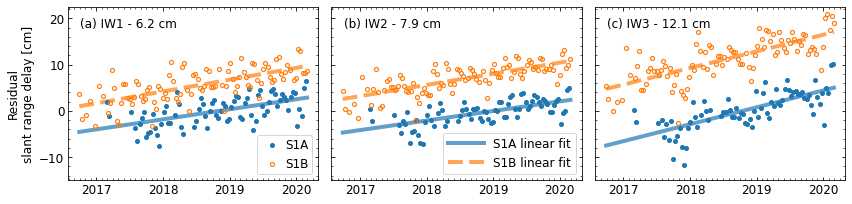

In [8]:
# input file & pts
ts_file = os.path.expanduser('~/data/geolocation/ChileSenDT156/mintpy_offset/timeseriesRg_SET_ERA5.h5')
pDict = {'IW1' : [-21.30, -67.39],
         'IW2' : [-21.30, -68.25],
         'IW3' : [-21.45, -69.15]}

# plot
cs = ['C0', 'C1']
#cmap = plt.get_cmap('magma', lut=6)
#cs = [cmap(0), cmap(3)]
biases = []
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[12, 3], sharey=True)
for i, (ax, label) in enumerate(zip(axs, list(pDict.keys()))):
    # read
    dates, ts_dis, ts_std, bias, flagA, flagB, dates_fit, ts_fitA, ts_fitB = get_timeseries_with_bias_est(ts_file, lalo=pDict[label])
    biases.append(bias)
    flag = flagA | flagB
    if i == 2:
        print('S1A/B num of dates: {} / {}'.format(np.sum(flagA), np.sum(flagB)))
        print('S1A/B date range: {} / {}'.format(np.min(dates[flag]), np.max(dates[flagB])))

    # plot
    p0A, = ax.plot(dates_fit, ts_fitA, '-',  color=cs[0], alpha=0.7, lw=4)
    p0B, = ax.plot(dates_fit, ts_fitB, '--', color=cs[1], alpha=0.7, lw=4)
    p1A, = ax.plot(dates[flagA], ts_dis[flagA], 'o', color=cs[0], mfc=cs[0],  ms=4, mew=1.0, label='S1A')
    p1B, = ax.plot(dates[flagB], ts_dis[flagB], 'o', color=cs[1], mfc='none', ms=4, mew=1.2, label='S1B')

    # axis format
    ax.tick_params(which='both', axis='both', direction='in', top=True, bottom=True, left=True, right=True)
    pp.auto_adjust_xaxis_date(ax, dates[flagB], buffer_year=None)
axs[0].set_ylim(ymin=-15)
axs[0].yaxis.set_minor_locator(ticker.AutoMinorLocator())
axs[0].set_ylabel('Residual\nslant range delay [cm]')
axs[0].legend(loc='lower right', ncol=1, handletextpad=0.1, borderpad=0.3)
axs[1].legend(loc='lower right', ncol=1, labels=['S1A linear fit', 'S1B linear fit'], handles=(p0A, p0B), handlelength=3.0)
fig.tight_layout()
for ax, num, IW, bias in zip(axs, ['(a)', '(b)', '(c)'], list(pDict.keys()), biases):
    ax.annotate('{} {} - {:.1f} cm'.format(num, IW, bias[0]), xy=(0.05, 0.88), xycoords='axes fraction', ha='left')

# output
out_fig = os.path.join(work_dir, 'S1AB_bias.pdf')
print('save figure to file', out_fig)
#plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()